# Определение возраста покупателей по фото

## Исследовательский анализ данных

**Заказчик.** Сетевой супермаркет «Хлеб-Соль»

**Цель Заказчика.** Определения возраста клиентов для анализа покупок и контроля кассиров при продаже алкоголя

**Цель исследования.** Постройте модель, которая по фотографии определит приблизительный возраст человека.

**Задачи:**
- Провести исследовательский анализ набора фотографий.
- Подготовите данные к обучению.
- Обучить нейронную сеть и рассчитать её качество

Входные данные от Заказчика. Папка с изображениями `/final_files` и csv-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

**Ожидаемый результат.** Построена модель, которая по фотографии может определить возраст человека с ошибкой не более 8 лет.

# Исследовательский анализ данных

In [1]:
# Импотрт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузим фотографии
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_directory('/datasets/faces/',
                                           target_size=(150, 150), 
                                           batch_size=16, 
                                           class_mode='sparse',
                                           seed=12345)

print(datagen_flow.class_indices)


Found 7591 images belonging to 1 classes.
{'final_files': 0}


In [3]:
features, target = next(datagen_flow)
print(features.shape)

(16, 150, 150, 3)


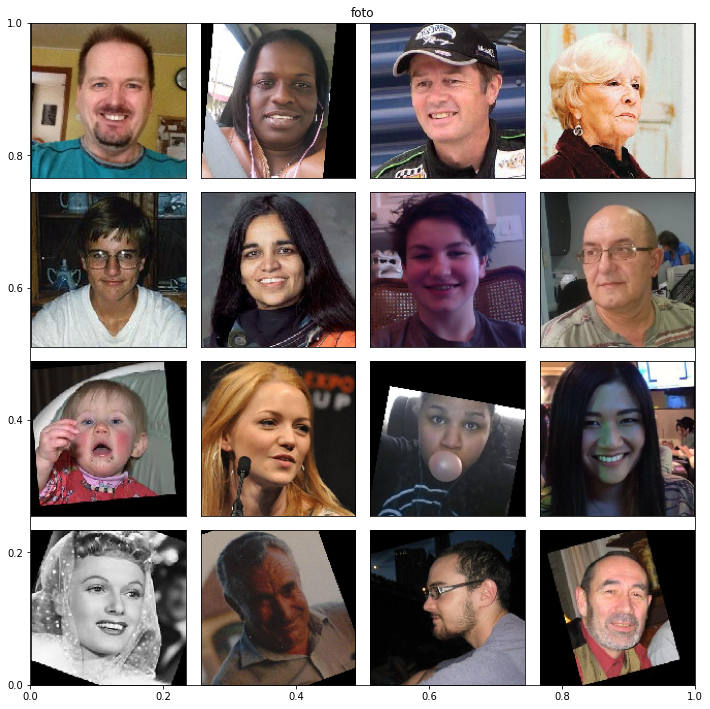

In [4]:
# Выведем на печать несколько фотографий
fig = plt.figure(figsize=(10,10))
plt.title('foto')
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

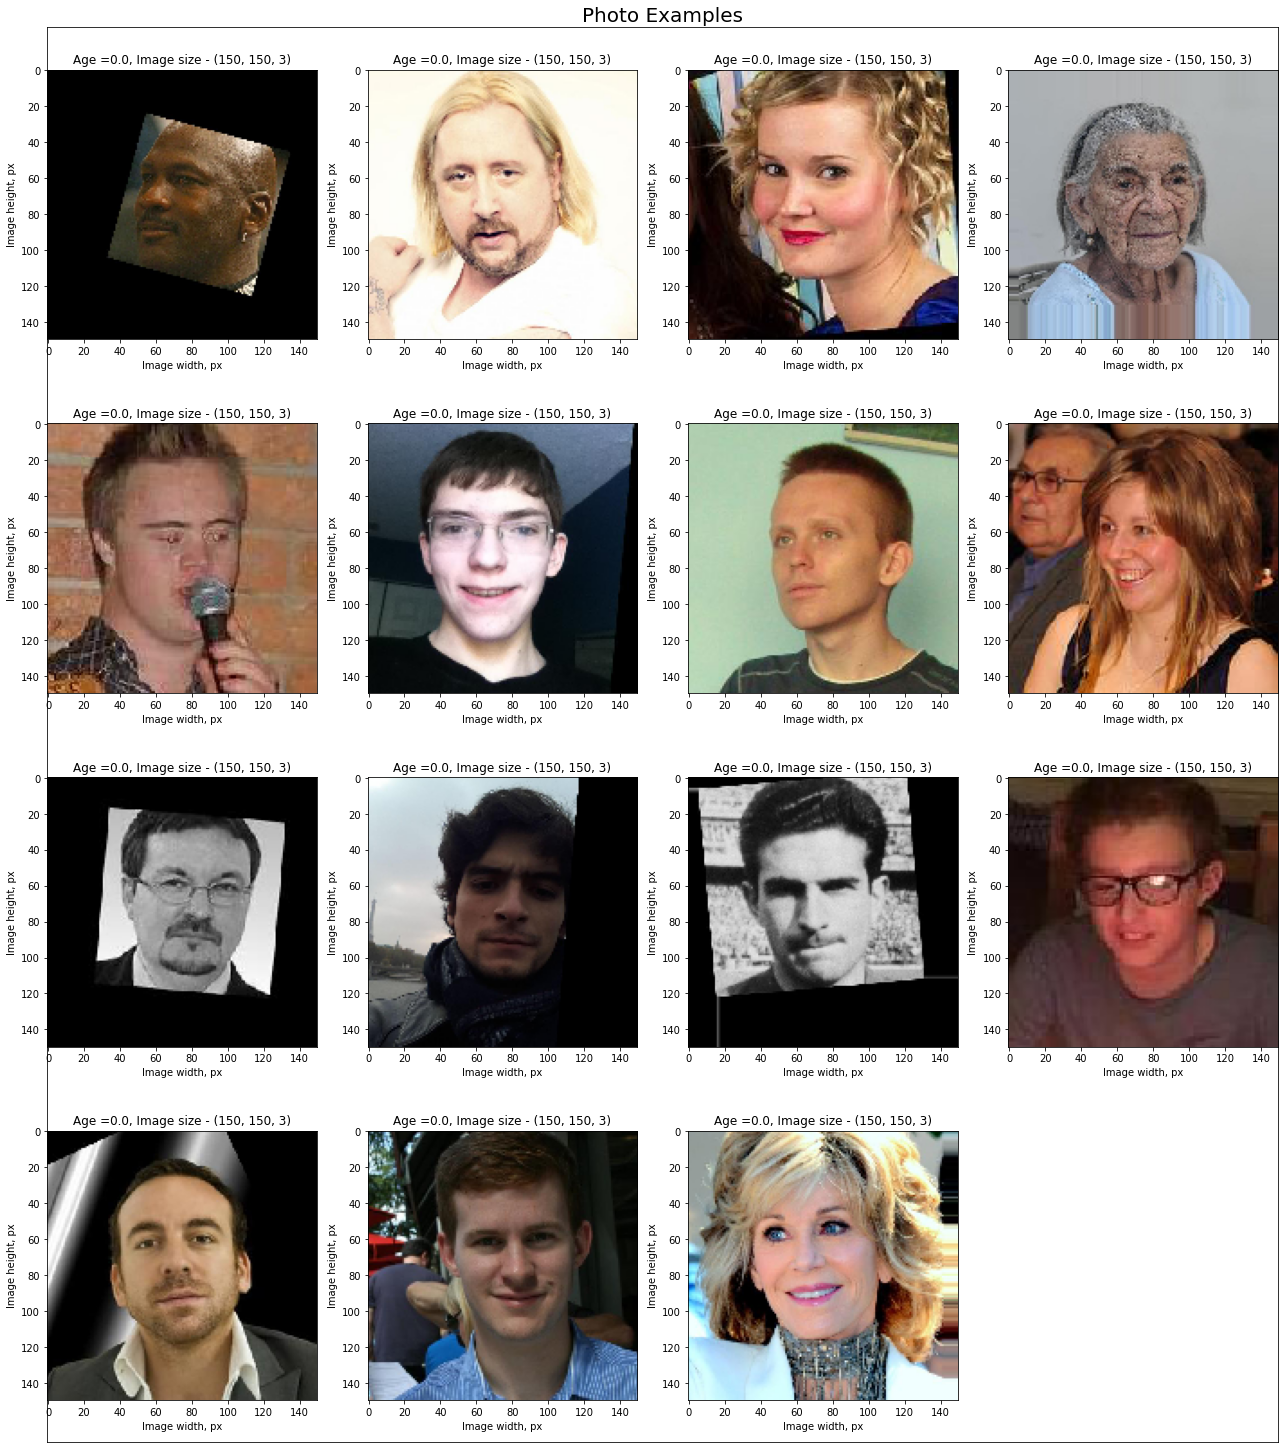

In [6]:
features, target = next(datagen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={}, Image size - {}'.format(target[i], features[i].shape), loc='center')    
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')

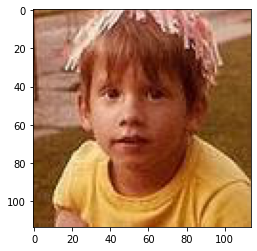

In [5]:
# Вывеедем на печать одну фотографию
image = Image.open('/datasets/faces/final_files/000000.jpg')
plt.imshow(np.array(image)) 

In [6]:
# Прочитаем файл с указанием возраста
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
# Изучим дата-сет методом info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


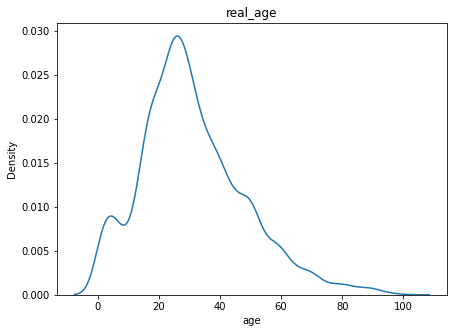

In [8]:
# Построем график распределения возраста
plt.figure(figsize=(7, 5))
sns.kdeplot(data=df['real_age'])
plt.xlabel("age")
plt.title('real_age')
plt.show()

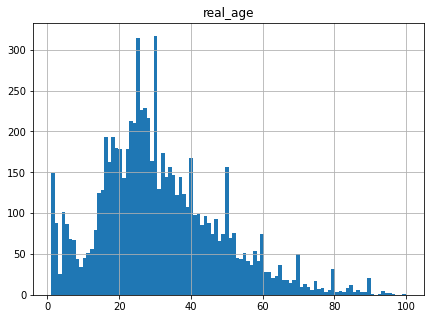

In [9]:
# Построем гистограмму распределения возраста
df['real_age'].hist(bins=100, figsize=(7,5))
plt.title('real_age')
plt.show()

In [9]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Выводы**

Набор данных содержит 7591 фотографию и дата-сет с указанием возраста для людей, изображенных на этих фотографиях.

Средний возраст составляет 31 год. Медианное значение возраста составляет 29 лет, что говорит о незначительном сдвиге вправо. Стандартное отклонение – 17 лет. 68% фотографий принадлежит людям в возрасте от 14 до 48 лет, что позволит добиться высокой точности модели.

Судя по распечатанным фотографиям, можно сделать несколько выводов:
1.	Фотографии ориентированы корректно
2.	Есть как цветные фотографии, так и черно-белые
3.	Размер фотографий – разный
4.	Есть фотографии со смещенной линией горизонта

Учитывая предоставленное количество фотографий, на некоторых возрастных группах (например, с 11 до 15 лет или после 60 лет) для качественного обучения будет недостаточно фотографий.

Для целей повышения качества обучения необходимо будет применять аугментацию


## Обучение модели

```Python

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    df = pd.read_csv(path+'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(dataframe = df,
                                                     directory = path+'/final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224), 
                                                     batch_size=32, 
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow


def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    df = pd.read_csv(path+'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(dataframe = df,
                                                    directory = path+'/final_files',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224), 
                                                    batch_size=32, 
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                       weights='imagenet',
                       include_top=False)
    
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```
    8192/94765736 [..............................] - ETA: 8s
   73728/94765736 [..............................] - ETA: 1:07
  253952/94765736 [..............................] - ETA: 42s 
  729088/94765736 [..............................] - ETA: 21s
 2056192/94765736 [..............................] - ETA: 9s 
 4530176/94765736 [>.............................] - ETA: 5s
 8937472/94765736 [=>............................] - ETA: 3s
13262848/94765736 [===>..........................] - ETA: 2s
16850944/94765736 [====>.........................] - ETA: 1s
20684800/94765736 [=====>........................] - ETA: 1s
25190400/94765736 [======>.......................] - ETA: 1s
29220864/94765736 [========>.....................] - ETA: 1s
32890880/94765736 [=========>....................] - ETA: 1s
37240832/94765736 [==========>...................] - ETA: 1s
41492480/94765736 [============>.................] - ETA: 0s
44769280/94765736 [=============>................] - ETA: 0s
48947200/94765736 [==============>...............] - ETA: 0s
53174272/94765736 [===============>..............] - ETA: 0s
57008128/94765736 [=================>............] - ETA: 0s
61186048/94765736 [==================>...........] - ETA: 0s
65200128/94765736 [===================>..........] - ETA: 0s
69230592/94765736 [====================>.........] - ETA: 0s
73277440/94765736 [======================>.......] - ETA: 0s
77463552/94765736 [=======================>......] - ETA: 0s
81502208/94765736 [========================>.....] - ETA: 0s
85549056/94765736 [==========================>...] - ETA: 0s
89661440/94765736 [===========================>..] - ETA: 0s
93446144/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-09-03 06:47:52.756143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-03 06:47:53.417924: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 65s - loss: 235.3960 - mae: 10.9687 - val_loss: 841.7591 - val_mae: 24.1242
Epoch 2/10
178/178 - 47s - loss: 75.8550 - mae: 6.5461 - val_loss: 904.9927 - val_mae: 25.2834
Epoch 3/10
178/178 - 49s - loss: 49.6264 - mae: 5.3177 - val_loss: 440.8123 - val_mae: 15.9346
Epoch 4/10
178/178 - 49s - loss: 35.7280 - mae: 4.5573 - val_loss: 173.6553 - val_mae: 9.5221
Epoch 5/10
178/178 - 65s - loss: 26.7132 - mae: 3.9661 - val_loss: 80.4421 - val_mae: 6.8665
Epoch 6/10
178/178 - 69s - loss: 20.4651 - mae: 3.4738 - val_loss: 67.5580 - val_mae: 6.2147
Epoch 7/10
178/178 - 69s - loss: 16.7827 - mae: 3.1201 - val_loss: 68.2173 - val_mae: 6.1168
Epoch 8/10
178/178 - 52s - loss: 12.8953 - mae: 2.7545 - val_loss: 66.5576 - val_mae: 6.0029
Epoch 9/10
178/178 - 66s - loss: 12.6536 - mae: 2.6847 - val_loss: 85.1029 - val_mae: 7.1272
Epoch 10/10
178/178 - 71s - loss: 10.8119 - mae: 2.5031 - val_loss: 70.5605 - val_mae: 6.5294
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 70.5605 - mae: 6.5294
Test MAE: 6.5294


```

## Анализ обученной модели

Лучший результат по MAE составил 6.5294.

Данный результат достигается с использованием модели из трех слоев: 
- первый слой – применена архитектура сверточной сети ResNet из 50-ти слоев без «верхушки»
- второй слой – сокращена параметров методом AveragePooling
- третий слой – полносвязаннй слой для целей регрессе (из одного нейрона) с функцией активизации ReLU

При поиске локальных минимумов использован метод Adam с начальным шагом 0.0001, в качестве функции потерь использована `Mean Squared Error`, в качестве метрики для определения качества прогноза использован `Mean Absolut Error`.

При загрузке из поученных данных выделена тестовая выборка в размере 25%. Лоя обучающей выборке применен метод аугментации с растяжением по горизонтале.

При обучении модели использовано 10 эпох

Исходя из целей заказчика определения возраста клиентов для анализа покупок и контроля кассиров при продаже алкоголя, погрешность созданной модели не позволит их достигнуть во полной мере. Предложенная модель позволяет проводить маркетинговый анализ покупок, однако, погрешность в 6,5 лет не позволит обеспечить контроль возраста при продаже алкоголя.

**Резюме.** Достигнут ожидаемый результат. Предложенная модель позволяет определить возраст человека по фотографии с ошибкой **6.5 лет**.
